<a href="https://colab.research.google.com/github/DARSHITA2804/DEEPLEARNING/blob/main/lab8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install torch torchvision torchaudio

!pip install tensorflow


In [ ]:
!pip install torchtext

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 61.1 MB/s eta 0:00:00


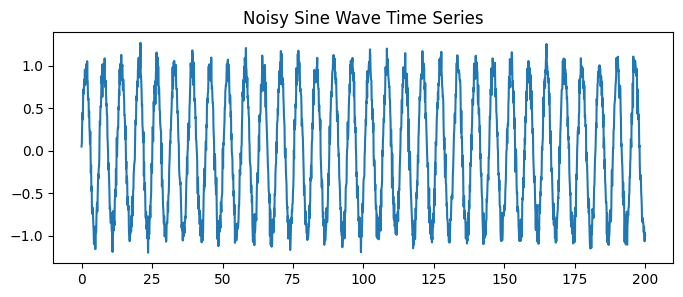

Epoch [1/25], Loss: 0.244074
Epoch [2/25], Loss: 0.018688
Epoch [3/25], Loss: 0.014108
Epoch [4/25], Loss: 0.013900
Epoch [5/25], Loss: 0.013592
Epoch [6/25], Loss: 0.012818
Epoch [7/25], Loss: 0.012583
Epoch [8/25], Loss: 0.012952
Epoch [9/25], Loss: 0.013004
Epoch [10/25], Loss: 0.013327
Epoch [11/25], Loss: 0.013180
Epoch [12/25], Loss: 0.012638
Epoch [13/25], Loss: 0.012094
Epoch [14/25], Loss: 0.011980
Epoch [15/25], Loss: 0.012476
Epoch [16/25], Loss: 0.012440
Epoch [17/25], Loss: 0.011978
Epoch [18/25], Loss: 0.011622
Epoch [19/25], Loss: 0.011909
Epoch [20/25], Loss: 0.012128
Epoch [21/25], Loss: 0.011904
Epoch [22/25], Loss: 0.012607
Epoch [23/25], Loss: 0.013057
Epoch [24/25], Loss: 0.011347
Epoch [25/25], Loss: 0.011999


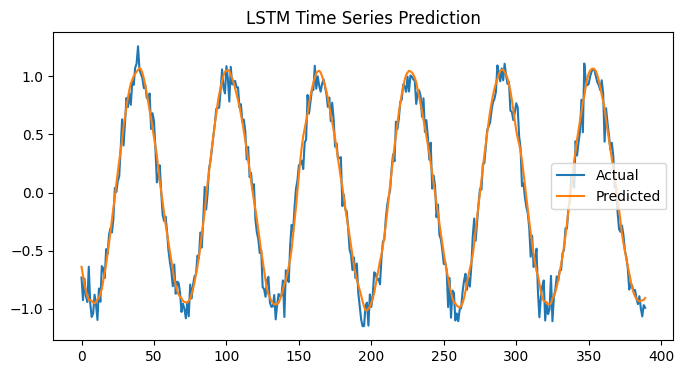

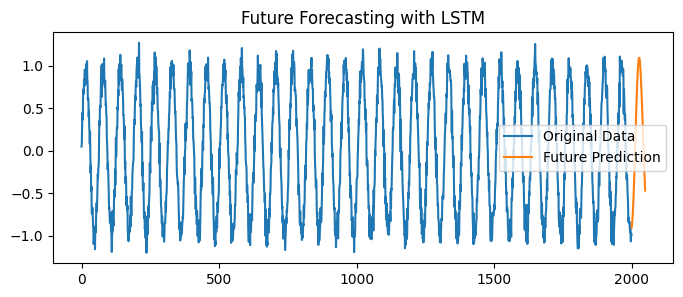

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, TensorDataset

np.random.seed(42)
time = np.arange(0, 200, 0.1)
data = np.sin(time) + 0.1 * np.random.randn(len(time))

plt.figure(figsize=(8,3))
plt.plot(time, data)
plt.title("Noisy Sine Wave Time Series")
plt.show()

def create_sequences(data, seq_length):
    xs, ys = [], []
    for i in range(len(data) - seq_length):
        x = data[i:i+seq_length]
        y = data[i+seq_length]
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

seq_length = 50
X, y = create_sequences(data, seq_length)

X = torch.tensor(X, dtype=torch.float32).unsqueeze(-1)  # (samples, seq_len, 1)
y = torch.tensor(y, dtype=torch.float32).unsqueeze(-1)  # (samples, 1)

train_size = int(0.8 * len(X))
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

train_loader = DataLoader(TensorDataset(X_train, y_train), batch_size=32, shuffle=True)


class LSTMRegressor(nn.Module):
    def __init__(self, input_size=1, hidden_size=64, num_layers=2):
        super(LSTMRegressor, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        out, _ = self.lstm(x)
        out = out[:, -1, :]   # use last time step
        out = self.fc(out)
        return out

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = LSTMRegressor().to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

num_epochs = 25
for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    for batch_X, batch_y in train_loader:
        batch_X, batch_y = batch_X.to(device), batch_y.to(device)
        optimizer.zero_grad()
        output = model(batch_X)
        loss = criterion(output, batch_y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {total_loss/len(train_loader):.6f}")


model.eval()
with torch.no_grad():
    preds = model(X_test.to(device)).cpu().numpy()
    actual = y_test.cpu().numpy()

plt.figure(figsize=(8,4))
plt.plot(range(len(actual)), actual, label='Actual')
plt.plot(range(len(preds)), preds, label='Predicted')
plt.legend()
plt.title("LSTM Time Series Prediction")
plt.show()


with torch.no_grad():
    seq = X_test[-1].unsqueeze(0).to(device)
    future_preds = []
    for _ in range(50):
        pred = model(seq)
        future_preds.append(pred.item())
        seq = torch.cat([seq[:, 1:, :], pred.unsqueeze(1)], dim=1)


plt.figure(figsize=(8,3))
plt.plot(range(len(data)), data, label='Original Data')
plt.plot(range(len(data), len(data)+50), future_preds, label='Future Prediction')
plt.legend()
plt.title("Future Forecasting with LSTM")
plt.show()
